# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела.





</div>

## Откройте и изучите файл

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump

<div class="alert alert-info"> <b>Комментарий студента:</b> Собирал все импорты в верхней части, чтобы легче было ориентироваться </div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Привет Алексей! Принято




</div>


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Собираем все импорты в верхней части, чтобы легче было ориентироваться и добавлять новые по необходимости. 


<div class="alert alert-warning">

Совет:     
    
    


- кстати есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html), в будущем пригодится )  


In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.isna().sum() 

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


**Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:**
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

👍 Данные изучены.


<div class="alert alert-warning">



Совет: 


Можно еще отдельно проверить датасет на сбалансированность классов в таргете. Это помогло бы решить бонусное задание сразу.




Можно посмотреть корреляцию признаков. Знаешь что такое мультиколлинеарность, какие два типа проблем возникает, для каких моделей и какие варианты решения?




</div>


## Разбейте данные на выборки

In [7]:
# отделим 20% данных для тестовой выборки (для проверки модели)
data_other, data_test = train_test_split(data, test_size=0.2, random_state=12345)


In [8]:
features_other = data_other.drop(['is_ultra'], axis=1) 
target_other = data_other['is_ultra']
features_test = data_test.drop(['is_ultra'], axis=1) 
target_test = data_test['is_ultra']

<div class="alert alert-info"> <b>Комментарий студента:</b> Исправил опечатку </div>

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Ошибка ❌:


Тут у тебя описка:
    
    
    
    features_other = data_test.drop(['is_ultra'], axis=1) 
    target_other = data_test['is_ultra']

    
    
    
</div>

In [9]:
# отделим 25% данных для validation выборки 
data_train, data_valid = train_test_split(data_other, test_size=0.25, random_state=12345) # < разделите данные на обучающую и валидационную выборки >

In [10]:
features_train = data_train.drop(['is_ultra'], axis=1) 
target_train = data_train['is_ultra']
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

In [11]:
print('Размер обучающей выборки', len(data_train))
print('Размер валидационной выборки', len(data_valid))
print('Размер тестовой выборки', len(data_test))

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


In [12]:
len(data) - (len(data_train) + len(data_valid) + len(data_test))

0

In [13]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [1339  589]
Количество строк в target_test по классам: [447 196]


In [14]:
def prop (data, column, set_name):
    result = round((data[column].sum()/len(data[column])*100), 2)
    return print(f'Доля в % абонентов «Ультра» в выборке {set_name}:',result)

In [15]:
prop(data_train,'is_ultra', '"Тренировочный набор"')
prop(data_valid,'is_ultra', '"Валидационный набор"')
prop(data_test,'is_ultra', '"Тестовый набор"')
prop(data,'is_ultra', '"Исходный набор"')

Доля в % абонентов «Ультра» в выборке "Тренировочный набор": 30.55
Доля в % абонентов «Ультра» в выборке "Валидационный набор": 31.1
Доля в % абонентов «Ультра» в выборке "Тестовый набор": 30.48
Доля в % абонентов «Ультра» в выборке "Исходный набор": 30.65


In [16]:
(data['is_ultra'].value_counts()/data.shape[0]).to_frame()

,is_ultra
0,0.693528
1,0.306472


<div class="alert alert-info"> <b>Комментарий студента:</b> Использовал классические пропорции 80-20-20. Проверили контроль разбиения использовав .shape. В начальной модели у нас 30.6 % пользователей Ультра. Сравним потом с итоговыми  (train/valid/test) </div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Отлично.
    
    
        




</div>


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:

Общепринято разбиение на test и validation так чтобы разница между ними была не больше чем в два раза (и не меньше чем по 10% от общего датасета )  Рекомендую использовать классические пропорции 80-20-20 (train/valid/test)
 

<div class="alert alert-warning">



Совет: 


- Обрати внимание на аргумент stratify, он позволит сохранить изначальное распределение таргетов во всех новых датасетах.  Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым. [Почитать](https://pythonru.com/baza-znanij/sklearn-train-test-split) можно тут


- После разбиения лучше перестраховаться и использовать .shape, для контроля за корректностью разбиения






## Исследуйте модели

### Модель случайный лес
* Использовал инфформацию для подбора параметров с сайта по ссылке https://habr.com/ru/company/ruvds/blog/488342/ для модели случайный лес 
* С помощью смены гиперпараметров подберем самые подходящие

#### Этап 1. Оптимизация гиперпараметров. RandomizedSearchCV
Начать можно с алгоритма RandomizedSearchCV, который позволяет довольно грубо исследовать широкие диапазоны значений

In [17]:
%%time
1 + 1
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 20)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
#В ходе работы мы генерируем сущность param_dist, содержащую, для каждого гиперпараметра, диапазон значений, которые нужно испытать
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
model = RandomizedSearchCV(RandomForestClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345)
model.fit(features_train, target_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
CPU times: user 748 ms, sys: 44 ms, total: 792 ms
Wall time: 1min 56s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 7, 12, 18, 23,
                                                             28, 34, 39, 44,
                                                             50],
                                        'min_samples_split': [2, 7, 12, 18, 23,
                                                              28, 34, 39, 44,
                                                              50],
                                        'n_estimators': [1, 53, 106, 158, 211,
                                                         263, 316, 369, 421,
                                                         474, 526, 579, 631,
                                                         684, 737, 789, 842,
                                                         894, 947, 1000]},
                   random_state=12345, verbose=1)

* При значениях параметров n_iter = 100 и cv = 3, мы создали 300 RF-моделей, случайно выбирая комбинации представленных выше гиперпараметров
* Для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск, мы легко можем получить датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV.

In [18]:
rs_df = pd.DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,106,34,7,sqrt,19,True,0.820548,1
1,526,23,2,log2,19,True,0.819504,2
2,421,39,7,log2,18,True,0.818990,3
3,789,34,7,sqrt,14,True,0.818989,4
4,106,34,7,sqrt,13,True,0.818471,5
...,...,...,...,...,...,...,...,...
95,1,28,39,sqrt,3,True,0.770756,96
96,1000,18,7,log2,1,True,0.769718,97
97,579,39,2,sqrt,1,False,0.766077,98
98,579,28,39,sqrt,1,True,0.760368,99


Теперь создадим столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. Это позволит понять то, какие значения гиперпараметров, в среднем, лучше всего себя показывают.

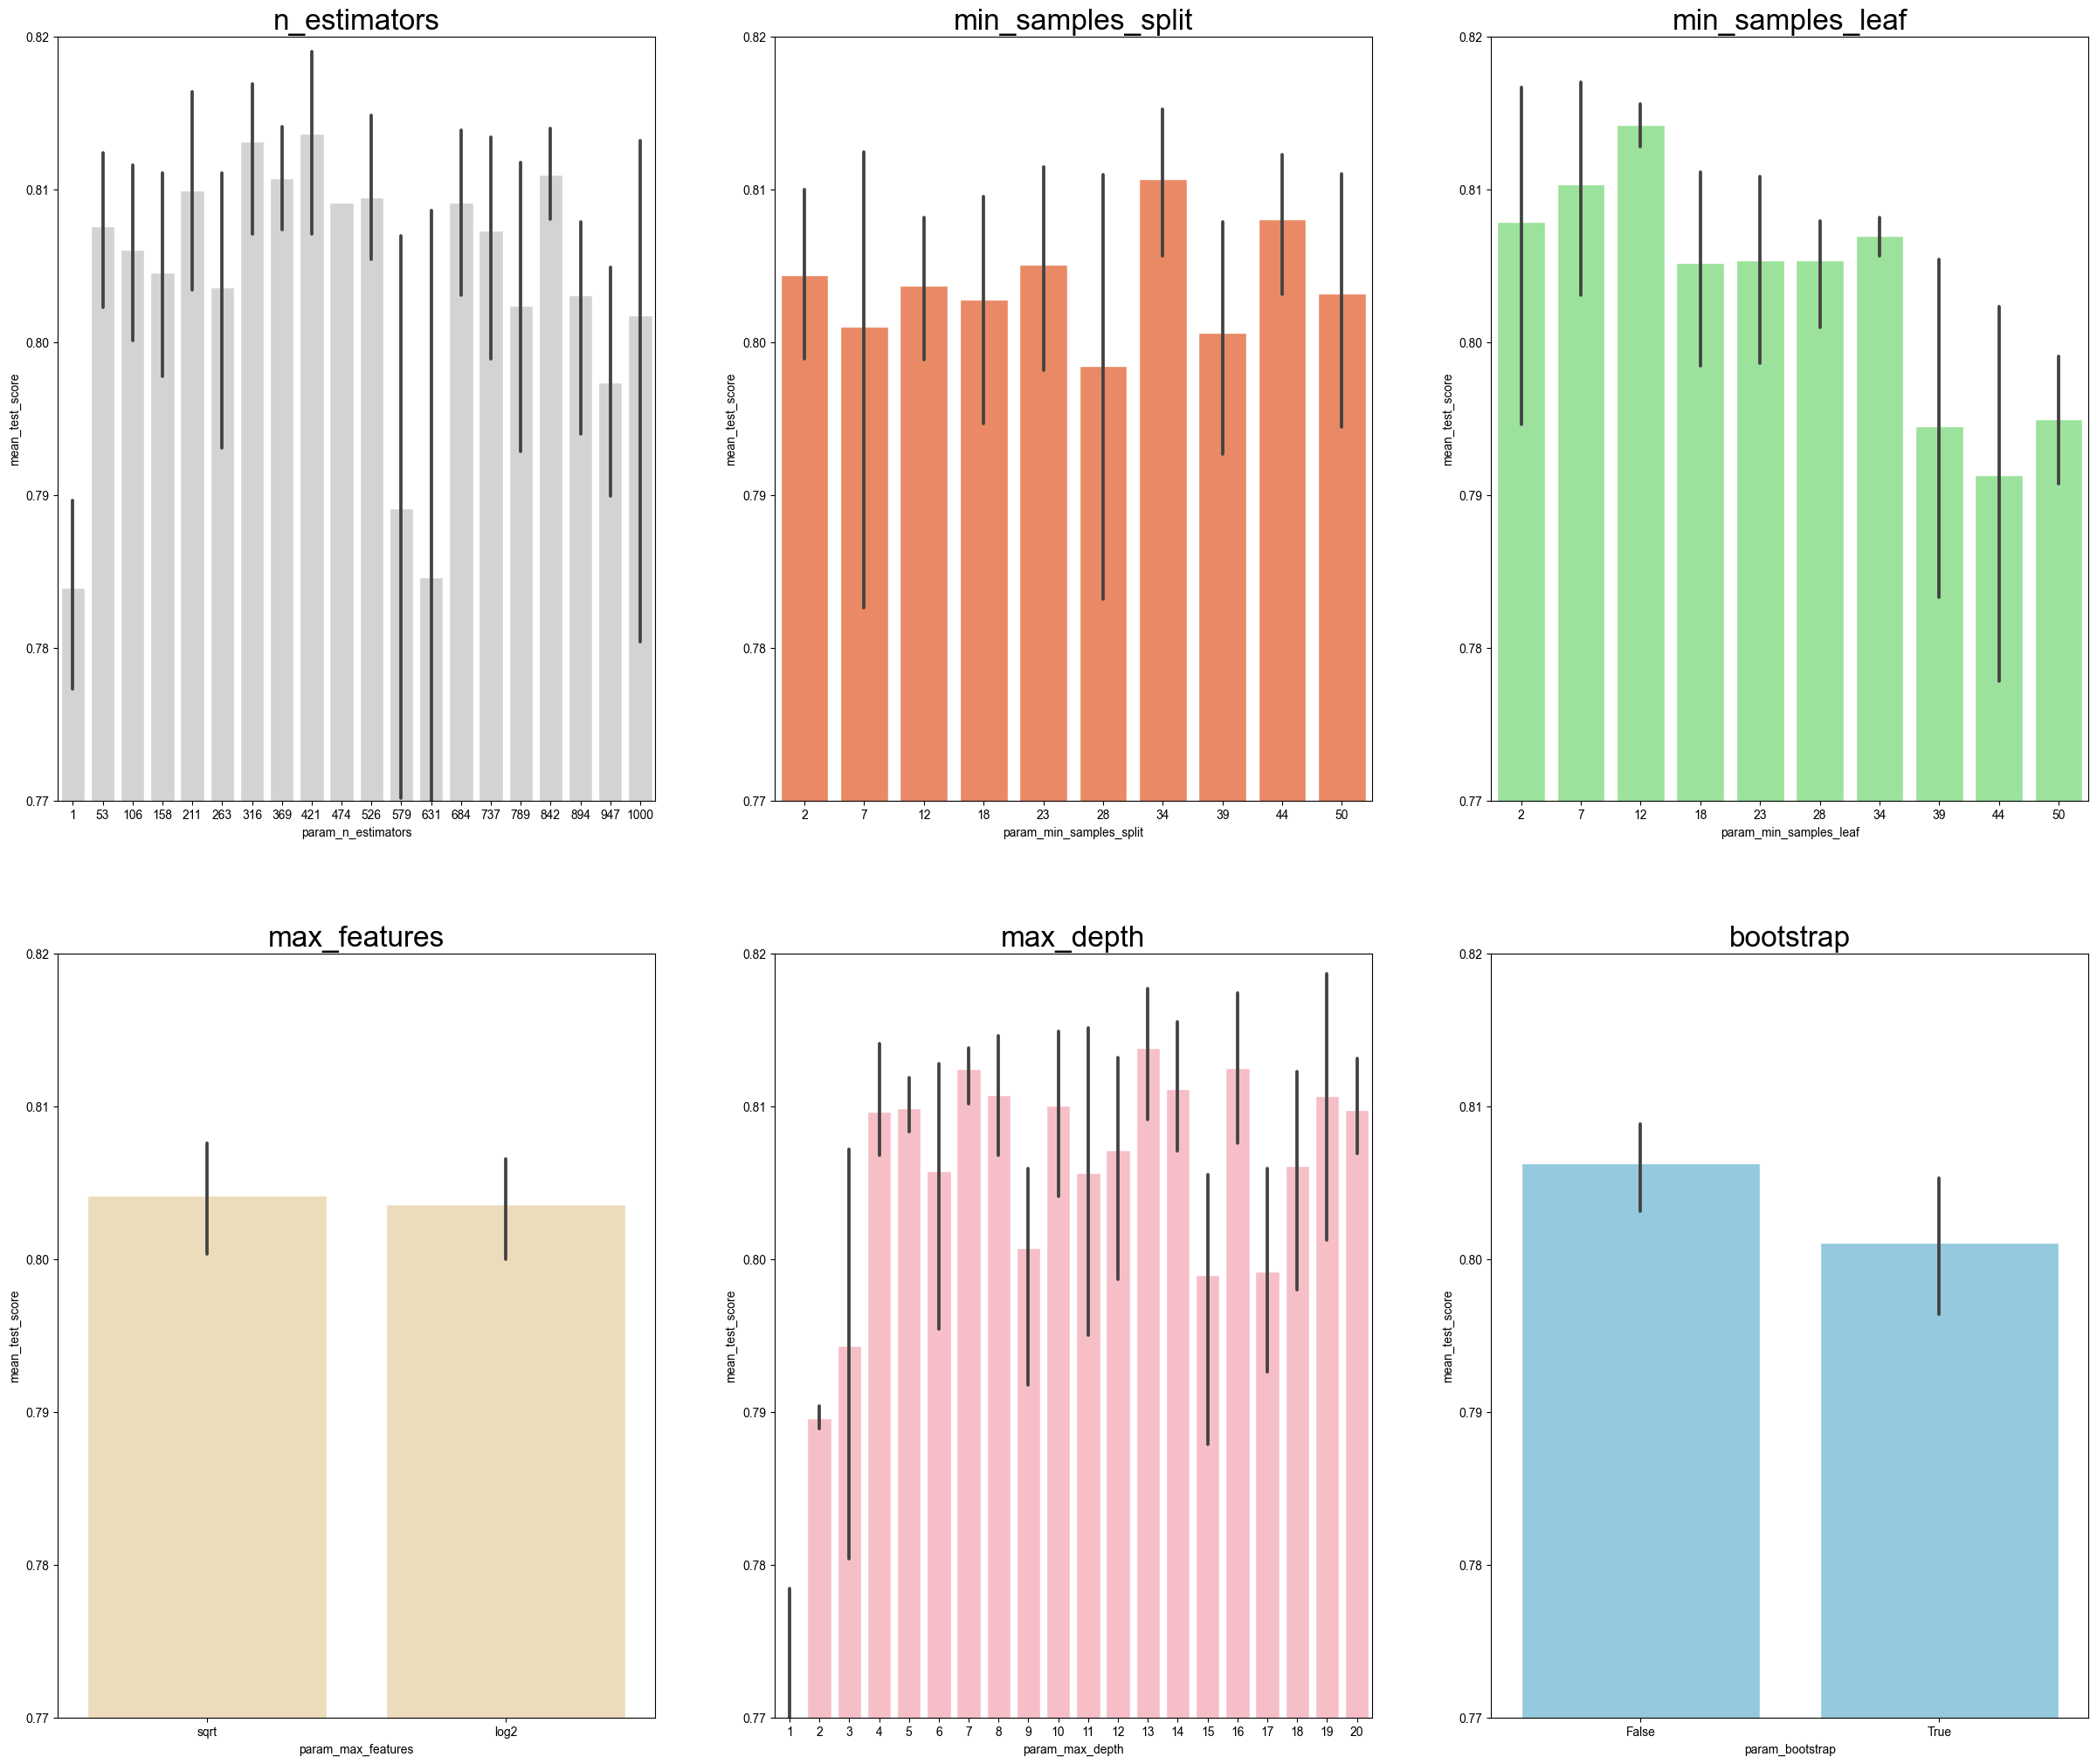

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.77,.82])
axs[0,0].set_title('n_estimators')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.77,.82])
axs[0,1].set_title('min_samples_split')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.77,.82])
axs[0,2].set_title('min_samples_leaf')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.77,.82])
axs[1,0].set_title('max_features')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.77,.82])
axs[1,1].set_title('max_depth')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.77,.82])
axs[1,2].set_title('bootstrap')

plt.show()

Анализируя графики можно увидеть некоторые закономеренности:
1. n_estimators - выберем лучшие параметры 316, 421, 842
2. min_samples_split - выберем лучшие параметры 23, 34, 44
3. min_samples_leaf - выберем лучшие параметры 2, 7, 12
4. max_features -  вариант sqrt и log2 даёт одинаковый результат.
5. max_depth - выберем лучшие параметры 4,5,7, 13
6. bootstrap - вариант False даёт самый высокий средний результат.

#### Этап 2. Оптимизация гиперпараметров. GridSearchCV

In [20]:
%%time
1 + 1
n_estimators = [316, 421, 842]
max_features = ['sqrt', 'log2']
max_depth = [4,5,7, 13]
min_samples_split = [23, 34, 44]
min_samples_leaf = [2, 7, 12]
bootstrap = [False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
model = GridSearchCV(RandomForestClassifier(), 
                     param_dist, 
                     cv = 3, 
                     verbose = 1, 
                     n_jobs=-1)
model.fit(features_other, target_other)
model.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
CPU times: user 5.69 s, sys: 48 ms, total: 5.74 s
Wall time: 5min 3s


RandomForestClassifier(bootstrap=False, max_depth=13, max_features='log2',
                       min_samples_leaf=2, min_samples_split=23,
                       n_estimators=842)

In [21]:
model.best_score_

0.8078568650330612

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Получил метрику на валидации




</div>


Здесь мы применяем кросс-валидацию по 3 блокам для 216 (3 x 2 x 4 x 3 x 3 x 1) сеансов обучения модели, что даёт 648 сеансов обучения модели, случайно выбирая комбинации представленных выше гиперпараметров. Мы можем обратиться к атрибуту best_params_ для получения сведений о наборе параметров, позволяющем создать самую лучшую модель.

<div class="alert alert-info"> <b>Комментарий студента:</b> Первоначально я не использовал GridSearchCV, у меня был перебор параметров RandomizedSearchCV. Теперь я добавил анализ полученных параметров RandomizedSearchCV, и выбор более подходящие. Все это необходимо, чтоб сократить время обработки через GridSearchCV. Которую обучил на конкетинированном наборе features_train c features_validation (features_other)
</div>



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



GridSearchCV,  RandomizedSearchCV  - для меня одно и тоже


RandomizedSearchCV, а затем GridSearchCV - Отлично, когда действительно перебором много dataset не будет учебный, это может быть полезным. 
    
    
    
    
    Которую обучил на конкетинированном наборе features_train c features_validation (features_other)
    
    
На самом деле нет, смотри ошибку выше    
</div>



<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка ❌:

Это не метрика на валидации:

    model.fit(features_train, target_train)
    model.score(features_valid, target_valid)

    
Что такое датасет валидационный!? По нему мы ищем лучшие значение гиперпараметры, а разве  по features_valid, target_valid  GS что-то перебирал!? Нет, об этой выборки он вообще представления не имеет 
    
    
Метрику на валидации смотрим тут .best_score_
    
    
    
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех:

Здорово что испробован GridSearchCV. Циклы позволяют нам изнутри посмотреть на процесс моделирования, есть ты уверен в своём понимании, то почему бы не использовать обёртку
    


<div class="alert alert-warning">

Совет:


- Не надо воспринимать  GS как способ получить .best_params_, чтобы подставить их в модель и обучить на них. GS это сделал уже и модельку положил тут: .best_estimator_
    
    
    
- GridSearch стоило обучить на конкетинированном наборе features_train c features_validation (или просто не нужно было отрезать валидационную выборку). Ведь GS из того что ты в него подал сделает внутри себя (причем несколько раз - кроссвалидация) валидационный и тренировочный датасет. А когда выберет лучшие значения для гиперпараметров, дообучится на всем датасете. То есть наш валидационный датасет ему не нужен. А ты получается искусственно уменьшаешь датасет с которым он работает, а значит у модели меньше шансов уловить закономерности. А откуда спросишь взять метрику на валидации?! Она тут  - .best_score_ 




    
Подытожим - GS все за нас сделал, нужно пользоваться  .best_score_ (чтобы отобрать лучшую модель среди прочих) и  .best_estimator_  (чтобы прогнозировать на тестовой)
    
    

- Когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить ))   

#### **Вывод:** 
*Наилучшие гиперпараметры для модели случайный лес при Accuracy = 0.8094126798910929:*
* 'n_estimators': 316
* 'min_samples_split': 44
* 'min_samples_leaf': 2
* 'max_features': 'log2'
* 'max_depth': 5
* 'bootstrap': False

### Модель Логистическая регрессия
* С помощью смены гиперпараметров подберем самые подходящие. С самым большим показателем Accuracy

In [22]:
model = LogisticRegression(solver = 'liblinear', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

0.6967340590979783

In [23]:
model = LogisticRegression(solver = 'saga', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

/home/aleksey/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.6936236391912908

In [24]:
model = LogisticRegression(solver = 'lbfgs', penalty = 'l2', multi_class ='auto', fit_intercept=True, dual=False, C=10,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

0.6920684292379471

In [25]:
model = LogisticRegression(solver = 'lbfgs', penalty = 'l2', multi_class ='auto', fit_intercept=False, dual=False, C=2,
                           random_state=12345, max_iter=1000) 
model.fit(features_train, target_train) # обучим модель по тренировочным данным

model.score(features_valid, target_valid)# посчитаем качество модели на валидационной выборке

0.6967340590979783

**Вывод:** 
*Наилучшие гиперпараметры для модели логистическая регрессия, полученное методом перебора с Accuracy 0.6998444790046656:*
* olver = 'lbfgs', 
* penalty = 'l2', 
* multi_class ='auto', 
* fit_intercept=True, 
* dual=False, 
* C=10,
* random_state=12345, 
* max_iter=1000

### Модель Дерево решений

In [26]:
best_model = None
best_result = 0
for depth in range(1, 6):
	model = DecisionTreeClassifier(max_depth=depth) # обучим модель с заданной глубиной дерева
	model.fit(features_train, target_train) # обучим модель
	predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
	result = accuracy_score(target_valid, predictions) # посчитаем качество модели
	if result > best_result:
		best_model = model
		best_result = result

print("Accuracy лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

Accuracy лучшей модели: 0.7651632970451011
max_depth лучшей модели: DecisionTreeClassifier(max_depth=3)


**Вывод:** 
*Наилучшие гиперпараметры для древа решений, полученное методом перебора с Accuracy 0.7651632970451011:*
* max_depth=3, 

<div class="alert alert-info"> <b>Комментарий студента:</b> Убрал random_state, построил графики как измеяется метрика при изменении гиперпараметров для модели случайный лес.
</div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:

Графика не вижу

</div>


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Не стоит указывать тут random_state 
</div>


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
 
Работа выполнена в соответствии с критериями: 



 - модель обучена на обучающем наборе
 - получена оценка качества на валидационном наборе
 - перебор гиперпараметров осуществляется в цикле





<div class="alert alert-warning">


Совет: 


- Можно добавить график, хорошо оформленный график украсит проект. Тут на графике можно посмотреть как при изменении гиперпараметров меняется точность на train и validation датасете (для этого собираем наши метрики на валидации и train в списки, а затем по ним обычный plt.plot()) Такой способ используют чтобы лучше отследить переобучение, но для этого стоит взять пернебор по max_depth поглубже



- tree_plot можно построить, с max_depth равной 3 или 4 (глубже уже будет громоздко) - глянуть как DT сплиты делает, будет понимание как модель принимает решения: какие признаки  использует, на каких значениях делает разбиение вправо - влево 




</div>



### Общий вывод по выбору модели
*Наилучшие гиперпараметры для модели случайный лес при Accuracy = 0.8094126798910929:*
* 'n_estimators': 316
* 'min_samples_split': 44
* 'min_samples_leaf': 2
* 'max_features': 'log2'
* 'max_depth': 5
* 'bootstrap': False

<div class="alert alert-info"> <b>Комментарий студента:</b> Метрику смотрим по валидационному датасету</b></font>

<div class="alert alert-warning">
    
    - Как назвать ситуацию, когда на валидации при увеличении глубины дерева (модель DT), метрика качества стала снижаться? Как по твоему в это же время вела себя эта же метрика на train? 
    
    Ответ: Это переобучение, на train происходило бы улучшение
    
    - Насколько знаю вы еще под капот моделям не заглядывали, но может знаешь почему обычно RF показывает более высокие результаты из выбранных?
    
    Ответ: Возможно она рассматривает больше количество вариантов. Больше сеасов обучения модели. Но и врем исполнения увеличивается
    
    - Мы решаем задачу классификации (а еще есть задача регрессии), а в названии модели с помощью которой мы решаем задачу "классификации" (Логистическая регрессия) есть слово "регрессия".  Нет ли тут парадокса? )
    
    Ответ: Нет парадокса. Логистическая регрессия - статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.
    
</div>


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>


Успех:


Дополню чуть

1. Верно, переобучение. На train точность растет вплоть до 100%. 
    
    
2. В RF обучается несколько деревьев, а решение принимается путем голосования. Каждое дерево в RF учится на своем датасете (используется техника бутстрап), таким образом достигается "независимость" этих самых деревьев, в итоге ошибка разброса снижается.

    
3. "Регрессия", потому что внутри нее скалярное произведение (как и в линейной регрессии), дающее на выходе вещественное число (от + бесконечности до - бесконечности), на это число вешают сигмойду, логарифм и получают значение от 0 до 1 (вероятность класса).   
    
    
4. Логистическая регрессия плоха (и хороша с другой стороны) тем что это линейный классификатор: обьекты на классы разделяем гиперплоскостью (прямой если на плоскости), а в данном датасете видимо более сложные, нелинейные связи между признаками и таргетом.   А RF с DT с этим справляются. На других данных  LR могла оказаться лучше, например потому что RF не может экстраполировать. 


</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Метрику смотрим по валидационному датасету
</div>


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Все верно, RF лучший.  Только смотреть надо на валидационном датасете метрику


<div class="alert alert-warning">


Совет: 

Если есть желание можешь ответить на вопросики ))    



- Как назвать ситуацию, когда на валидации при увеличении глубины дерева (модель DT), метрика качества стала снижаться? Как по твоему в это же время вела себя эта же метрика на train?


- Насколько знаю вы еще под капот моделям не заглядывали, но может знаешь почему обычно RF показывает более высокие результаты из выбранных?


- Мы решаем задачу классификации (а еще есть задача регрессии), а в названии модели с помощью которой мы решаем задачу "классификации" (Логистическая регрессия) есть слово "регрессия".  Нет ли тут парадокса? )
    

- Почему логистическая регрессия показывать на много более худшие результаты?  

</div>


## Проверьте модель на тестовой выборке

In [27]:
model = RandomForestClassifier(n_estimators = 316, min_samples_split = 44, min_samples_leaf = 2, 
                               max_features ='log2', max_depth = 5, bootstrap = False, n_jobs=-1,
                               verbose = 1) # обучите модель с заданным гиперпараметрами
model_RFC_final_prediction = model.fit(features_test, target_test)
predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
result = accuracy_score(target_valid, predictions) # посчитайте качество модели на валидационной выборке

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


<div class="alert alert-info"> <b>Комментарий студента:</b> В придыдущем варианте было не верно поситано accuraсy = 0.8. В данном варианте более правдивые результаты accuraсy = 0.7744945567651633 
    
Доля клиентов с тарифом "Ультра" в начальной выборке 0.69. Наши модели показывают большую точность, они выявили закономерности, позволяющие предложить новым пользователям тариф

</div>



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель (или парочку, если метрики были близки) отобранную на валидации. 

- Если студент получил на тесте accuraсy  выше 0,78, это считается отличным результатом. Ты подбираешь лучшую комбинацию не по одному гиперпараметру и вот он результат!


<div class="alert alert-warning">

Вопросики и совет:



    
- А можешь предложить как нам использовать полученный результат в бизнесе? Как нам на этих прогнозах сделать деньги? 




- Алексей, в качестве бонуса можешь вывести еще несколько метрик своей модели - precision, recall, F1 и confussion matrix) Все есть в sklearn)



In [28]:
print("Accuracy лучшей модели:", result)

Accuracy лучшей модели: 0.7713841368584758


<div class="alert alert-info"> <b>Комментарий студентаV2:</b> В придыдущем варианте было не верно поситано accuraсy = 0.8. В данном варианте более правдивые результаты accuraсy = 0.7698289269051322. В предыдущей варианте я обуение и проверку проводил на тестой выборке, поэтому у меня получились высокие значения </div>

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:


А теперь она у тебя получилась ниже, при том числе переборов что ты делал.  Всё дело в том что ты напутал с выборками.
</div>


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Метрика очень высокая, такого не может быть
</div>


## (бонус) Проверьте модели на адекватность

Проверим модели на вменяемость. Для это построим случайную модель на основе DummyClassifier, попробуем посмотреть количественные характеристики по выборке столбца is_ultra

In [29]:
strategies = ['most_frequent', 'stratified', 'uniform']
dummies_result = []
for strat in strategies:
    dc = DummyClassifier(strategy=strat, random_state=42)
    dc.fit(features_train, target_train)
    res = dc.score(features_test, target_test)
    dummies_result.append({strat:res})

pd.DataFrame(dummies_result).fillna(0)

,most_frequent,stratified,uniform
0,0.695179,0.000000,0.000000
1,0.000000,0.589425,0.000000
2,0.000000,0.000000,0.496112


Самый лучший вариант, что мы получили алгоритмом - 0.695, в то время как наши модели показывают правильность больше 0.7744945567651633.

Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

In [30]:
(data['is_ultra'].value_counts()/data.shape[0]).to_frame()

,is_ultra
0,0.693528
1,0.306472


Доля клиентов с тарифом "Ультра" в начальной выборке 69,35 %. Наши модели показывают большую точность, они выявили закономерности, позволяющие предложить новым пользователям тариф

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Все верно. 

👍 что используешь специальную обертку для проверки на адекватность



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>




Алексей, у тебя старательно выполненная работа, все четко, осмысленно. Cкомментированием кода тоже никаких проблем нет, твоих объяснений достаточно для понимания коллегами хода твоих мыслей. 



Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить): 




- обрати внимание на проверку сбалансированность классов в таргете в разделе EDA
- использовать stratify
- добавить график метрики    


Замечания на будущее:
    


- Было бы замечательно, в выводе немножко о данных, работе с ними (пусть даже никакой работы и не было), моделировании и полученных результатах. Это важно потому что когда проект захочет посмотреть будущий работодатель (или начальник), у него может не быть времени на подробный разбор кода. Вероятнее всего он бегло просмотрит код, а из общего вывода захочет получить представление о всей работе.

 
    
Обязательное к исправлению:



- Рекомендую соблюдать классический пропорции между выборами



- Когда используешь GS метрику на валидации смотрим с помощью .best_score_

Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


</div>




<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    


Что осталось из красного:

Обрати внимание на этот код:

    features_other = data_test.drop(['is_ultra'], axis=1) 
    target_other = data_test['is_ultra']
    features_test = data_test.drop(['is_ultra'], axis=1) 
    target_test = data_test['is_ultra']

    
    
На связи

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
